### Celda para inferir en dataset COCO

In [3]:
import os
import time
import subprocess

# Ruta al ejecutable de OpenPose
openpose_executable = "bin\\OpenPoseDemo.exe"

# Directorio de imágenes
image_dir = "../../dataset/val2017"

# Archivo de salida JSON
output_json = "predict_coco_test_tiempo.json"

# Comando para ejecutar OpenPose
command = [
    openpose_executable,
    "--image_dir", image_dir,
    "--write_coco_json", output_json,
    "--write_coco_json_variants", "2",
    "--display", "0",
    "--render_pose", "0" 
]

# Medir el tiempo de ejecución
start_time = time.time()

# Ejecutar OpenPose y capturar la salida
result = subprocess.run(command, capture_output=True, text=True)

# Calcular el tiempo total de ejecución
end_time = time.time()
total_time = end_time - start_time

# Contar el número de imágenes procesadas
num_images = len([name for name in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, name))])

# Calcular los FPS (frames per second)
fps = num_images / total_time

print(f"Procesado {num_images} imágenes en {total_time:.2f} segundos.")
print(f"FPS estimados: {fps:.2f}")

# Mostrar la salida de OpenPose para verificar si hay errores o advertencias
print("Salida de OpenPose:")
print(result.stdout)

if result.stderr:
    print("Errores de OpenPose:")
    print(result.stderr)

Procesado 5000 imágenes en 3907.79 segundos.
FPS estimados: 1.28
Salida de OpenPose:
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 3906.716667 seconds.



### Celda para inferir videos

In [35]:
import os
import time
import subprocess

# Ruta al ejecutable de OpenPose
openpose_executable = "bin\\OpenPoseDemo.exe"

# Ruta al archivo de video
video_path = "examples/media/prueba.mp4"

# Archivo de salida JSON
output_json = "output_openpose.json"

# Comando para ejecutar OpenPose en un video
command = [
    openpose_executable,
    "--video", video_path,
    "--write_coco_json", output_json,
    "--write_coco_json_variants", "2",
]

# Medir el tiempo de ejecución
start_time = time.time()

# Ejecutar OpenPose y capturar la salida
result = subprocess.run(command, capture_output=True, text=True)

# Calcular el tiempo total de ejecución
end_time = time.time()
total_time = end_time - start_time

# Obtener la cantidad de frames en el video
import cv2
video = cv2.VideoCapture(video_path)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
video.release()

# Calcular los FPS (frames per second)
fps = total_frames / total_time

print(f"Procesado {total_frames} frames en {total_time:.2f} segundos.")
print(f"FPS estimados: {fps:.2f}")

# Mostrar la salida de OpenPose para verificar si hay errores o advertencias
print("Salida de OpenPose:")
print(result.stdout)

if result.stderr:
    print("Errores de OpenPose:")
    print(result.stderr)

Procesado 728 frames en 198.37 segundos.
FPS estimados: 3.67
Salida de OpenPose:
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 197.549203 seconds.



#### Evaluar visualmente un conjunto de puntos

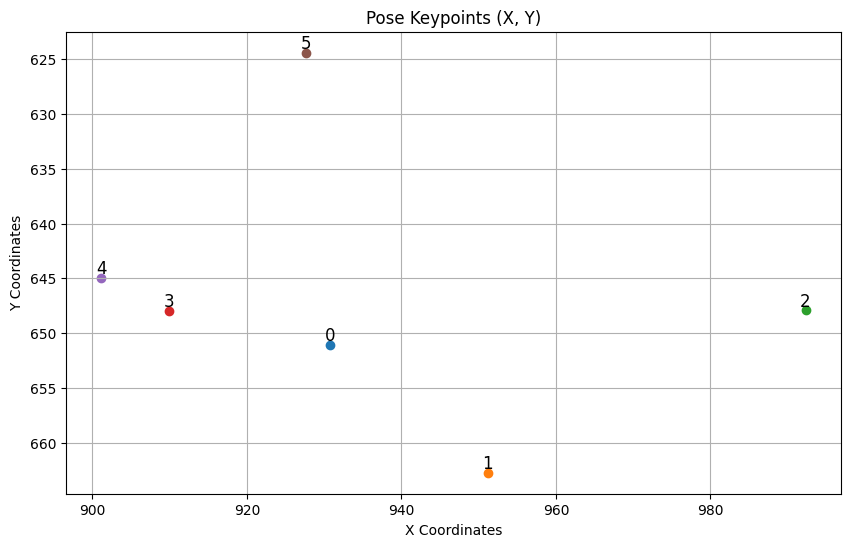

In [37]:
import matplotlib.pyplot as plt

# Información proporcionada
data = {
    "image_id": 0,
    "category_id": 1,
    "keypoints": [
        930.722,651.037,1,951.189,662.738,1,992.32,647.883,1,909.902,647.967,1,901.115,644.945,1,927.698,624.405,1
	],
    "score": 0.883655
}

# Extraer las coordenadas x, y y los ids
keypoints = data['keypoints']
points = [(keypoints[i], keypoints[i + 1], i // 3) for i in range(0, len(keypoints), 3)]

# Graficar los puntos
plt.figure(figsize=(10, 6))
for x, y, point_id in points:
    plt.scatter(x, y, label=f'ID {point_id}')
    plt.text(x, y, str(point_id), fontsize=12, ha='center', va='bottom')

# Añadir etiquetas y título
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Pose Keypoints (X, Y)')
plt.grid(True)
plt.gca().invert_yaxis()  # Invertir el eje y para coincidir con las coordenadas típicas de una imagen

# Mostrar la gráfica
plt.show()


### Algoritmo de detección de pasos

In [58]:
import cv2
import json
import numpy as np
import os
import subprocess
import json

#### Primero paso, inferir con OpenPose

In [68]:
# Función para crear un directorio si no existe
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Función para procesar el video y guardar los cuadros como imágenes
def extract_frames(video_path, output_directory_frames):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_filename = os.path.join(output_directory_frames, f'frame_{frame_count:04d}.jpg')
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()

# Configuración
video_path = 'prueba.mp4'
output_directory_frames = './output_analysis/output_directory_frames/frames'

# Crear directorio de cuadros
create_directory(output_directory_frames)

# Extraer cuadros del video
extract_frames(video_path, output_directory_frames)

# Ejecutar OpenPose en las imágenes guardadas
command = [
    "bin\\OpenPoseDemo.exe",
    "--video", video_path,
    "--write_coco_json", "output_json_puro.json",
    "--write_coco_json_variants", "2",
    "--display", "0",
    "--render_pose", "0" 
]
result = subprocess.run(command, capture_output=True, text=True)

# Verificar si OpenPose se ejecutó correctamente
if result.returncode != 0:
    print(f"Error al ejecutar OpenPose: {result.stderr}")
else:
    print(f"Salida de OpenPose: {result.stdout}")

# Verificar la creación del archivo JSON
json_file_path = "output_json_puro_foot.json" # La extension _foot proviene de la flag json_variants 2, para mas información leer la documentación
if not os.path.exists(json_file_path):
    print(f"El archivo {json_file_path} no se ha creado.")
else:
    print(f"El archivo {json_file_path} ha sido creado exitosamente.")

Salida de OpenPose: Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 197.300374 seconds.

El archivo output_json_puro_foot.json ha sido creado exitosamente.


#### Paso dos, filtrar detecciones con la persona de mayor confianza, esto para casos en las que hayan detecciones no deseadas, por lo general estas deberian tener menor score

In [71]:
# Función para filtrar las detecciones de OpenPose
def filter_detections(data):
    image_scores = {}
    for entry in data:
        image_id = entry["image_id"]
        score = entry["score"]
        if image_id not in image_scores or score > image_scores[image_id]["score"]:
            image_scores[image_id] = entry
    return list(image_scores.values())

# Leer el archivo JSON generado por OpenPose
with open("output_json_puro_foot.json", 'r') as file:
    data = json.load(file)

# Filtrar las detecciones para quedarse solo con la de mayor confianza por imagen
filtered_data = filter_detections(data)

# Guardar el JSON filtrado
with open('filtered_output_json.json', 'w') as file:
    json.dump(filtered_data, file, indent=4)

print("Filtrado de datos completado. El archivo 'filtered_output_json.json' ha sido creado.")

Filtrado de datos completado. El archivo 'filtered_output_json.json' ha sido creado.


#### Paso tres, correr algoritmo completo de detección de pasos mas procesamiento del output

In [73]:
# Variables globales necesarias
Dx_left_s, Dy_left_s, Dx_right_s, Dy_right_s = [], [], [], []
left_rects_s, right_rects_s = [], []
last_step_left_idx, last_step_right_idx = -1, -1
last_step_left_bbox, last_step_right_bbox = None, None
min_displacement = 10  # Ajusta según sea necesario
weights = [4, 2, 1]  # Ejemplo de pesos

# Funciones auxiliares
def step_criteria_advanced(index, Dx, Dy, left):
    global last_step_left_idx, last_step_right_idx, last_step_left_bbox, last_step_right_bbox
    if abs(Dx) < min_displacement and abs(Dy) < min_displacement:  # Evident case, no significant movement
        if left:
            last_step_left_idx = index
            last_step_left_bbox = left_rects_s[index]
        else:
            last_step_right_idx = index
            last_step_right_bbox = right_rects_s[index]
        return True
    elif index > 0:  # Check displacement orientation change
        if abs(Dy) < min_displacement:  # Insignificant y displacement
            if orientation_change(index, Dx, left, True):  # If x orientation changes, means a step occurred
                if left:
                    last_step_left_idx = index
                    last_step_left_bbox = left_rects_s[index]
                else:
                    last_step_right_idx = index
                    last_step_right_bbox = right_rects_s[index]
                return True
        else:  # Significant y displacement: check if it changes signs significantly (shall be a step)
            if orientation_change(index, Dy, left, False):  # If orientation changes, means
                if left:
                    last_step_left_idx = index
                    last_step_left_bbox = left_rects_s[index]
                else:
                    last_step_right_idx = index
                    last_step_right_bbox = right_rects_s[index]
                return True
    return False

def orientation_change(index, value, left, is_x):
    if value == 0:
        return False
    global last_step_left_idx, last_step_right_idx
    d, acc_d = 0, 0
    last_step_idx = last_step_left_idx if left else last_step_right_idx
    crit = 0 if last_step_idx == -1 else last_step_idx

    D = Dx_left_s if left else Dx_right_s
    if not is_x:
        D = Dy_left_s if left else Dy_right_s

    for i in range(index - 1, crit - 1, -1):
        d = D[i]
        acc_d += d
        if d == 0:
            continue
        if (value > 0 and d < 0) or (value < 0 and d > 0):
            if abs(acc_d) > min_displacement:
                return True

    return False

def smooth_displacement(index):
    global Dx_left_s, Dy_left_s, Dx_right_s, Dy_right_s
    if index >= len(Dx_left_s) or index >= len(Dy_left_s) or index >= len(Dx_right_s) or index >= len(Dy_right_s):
        return 

    sum_dx_left = weights[0] * Dx_left_s[index]
    sum_dy_left = weights[0] * Dy_left_s[index]
    sum_dx_right = weights[0] * Dx_right_s[index]
    sum_dy_right = weights[0] * Dy_right_s[index]
    norm = weights[0]
    s = len(Dx_left_s)
    for i in range(index + 1, min(s, index + 3)):
        j = i - index
        sum_dx_left += weights[j] * Dx_left_s[i]
        sum_dy_left += weights[j] * Dy_left_s[i]
        sum_dx_right += weights[j] * Dx_right_s[i]
        sum_dy_right += weights[j] * Dy_right_s[i]
        norm += weights[j]
    for i in range(index - 1, max(-1, index - 3), -1):
        j = index - i
        sum_dx_left += weights[j] * Dx_left_s[i]
        sum_dy_left += weights[j] * Dy_left_s[i]
        sum_dx_right += weights[j] * Dx_right_s[i]
        sum_dy_right += weights[j] * Dx_right_s[i]
        norm += weights[j]
    Dx_left_s[index] = sum_dx_left / norm
    Dy_left_s[index] = sum_dy_left / norm
    Dx_right_s[index] = sum_dx_right / norm
    Dy_right_s[index] = sum_dy_right / norm

# Función para dibujar los puntos clave de la pose
def draw_pose(frame, keypoints):
    for i in range(0, len(keypoints), 3):
        x = int(keypoints[i])
        y = int(keypoints[i + 1])
        cv2.circle(frame, (x, y), 3, (0, 0, 255), -1)  # Dibuja círculos en los puntos clave

# Crear directorio si no existe
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Configuración
video_path = 'prueba.mp4'
output_directory = './output_analysis'
output_directory_frames = os.path.join(output_directory, 'frames_with_pose')

# Crear directorios
create_directory(output_directory)
create_directory(output_directory_frames)

# Leer el JSON filtrado
with open('filtered_output_json.json', 'r') as file:
    filtered_data = json.load(file)

# Procesar los cuadros y detectar pasos
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

frames_info = []

out = cv2.VideoWriter(os.path.join(output_directory, 'output_with_steps.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
steps = 0
frame_idx = 0
left_points = []
right_points = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    stepDetection = False  # solo cambia si se detecta la pisada

    for detection in filtered_data:
        if detection['image_id'] == frame_idx:
            keypoints = detection["keypoints"]
            left_ankle = (int(keypoints[6]), int(keypoints[7]))
            right_ankle = (int(keypoints[15]), int(keypoints[16]))

            left_point = left_ankle
            right_point = right_ankle

            # Dibujar la pose en el frame
            draw_pose(frame, keypoints)

            if frame_idx > 0:
                dx_left = left_point[0] - left_points[-1][0]
                dy_left = left_point[1] - left_points[-1][1]
                dx_right = right_point[0] - right_points[-1][0]
                dy_right = right_point[1] - right_points[-1][1]

                Dx_left_s.append(dx_left)
                Dy_left_s.append(dy_left)
                Dx_right_s.append(dx_right)
                Dy_right_s.append(dy_right)

                left_rects_s.append(left_point)
                right_rects_s.append(right_point)

                smooth_displacement(frame_idx)
                
                if step_criteria_advanced(frame_idx - 1, Dx_left_s[-1], Dy_left_s[-1], True):
                    cv2.circle(frame, left_point, 10, (0, 255, 0), -1)
                    steps += 1
                    stepDetection = True
                if step_criteria_advanced(frame_idx - 1, Dx_right_s[-1], Dy_right_s[-1], False):
                    cv2.circle(frame, right_point, 10, (0, 255, 0), -1)
                    steps += 1
                    stepDetection = True

            left_points.append(left_point)
            right_points.append(right_point)

    # Mostrar indicador de pisada en pantalla
    if stepDetection:
        cv2.putText(frame, 'Step Detected', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(frame, 'No Step', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

    # Guardar el frame con la pose y detección de pisadas
    frame_filename = os.path.join(output_directory_frames, f'frame_{frame_idx:04d}.jpg')
    cv2.imwrite(frame_filename, frame)

    frame_info = {
        'frame_index': frame_idx,
        'stepDetection': stepDetection,
        'file_name': frame_filename
    }
    frames_info.append(frame_info)

    out.write(frame)
    frame_idx += 1

cap.release()
out.release()

# Guardar la información de los cuadros en un archivo JSON
json_filename = os.path.join(output_directory, 'frames_info.json')
with open(json_filename, 'w') as json_file:
    json.dump(frames_info, json_file, indent=4)

print(f"Detección de pasos completada. Los archivos han sido guardados en el directorio {output_directory}.")

Detección de pasos completada. Los archivos han sido guardados en el directorio ./output_analysis.
